# EX2: CBC-GW Injection
In this example we load an LVK posterior from zenodo and compute the FI evidence for the CBC model.

In [1]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
import bilby
import numpy as np
import os, shutil
from collections import namedtuple
import logging
import matplotlib.pyplot as plt
from funnel.plotting import plot_fi_evidence_results
from funnel.fi_core import get_fi_lnz_list

np.random.seed(42)

CLEAN = False
OUTDIR = 'out_gwinj'

if os.path.exists(OUTDIR) and CLEAN:
    shutil.rmtree(OUTDIR)
os.makedirs(OUTDIR, exist_ok=True)

## Simple 2-parameter inferece
### Nested sampling LnZ Calculation

In [5]:
bilby_logger = logging.getLogger("bilby")
bilby_logger.setLevel(logging.CRITICAL)

label = "injection"
res_fname = f"{OUTDIR}/{label}_result.json"

if not os.path.exists(res_fname):

    # Simulate signal
    duration, sampling_freq, min_freq = 4, 1024., 20
    injection_parameters = dict(
        mass_1=36.0, mass_2=29.0,  # 2 mass parameters
        a_1=0.1, a_2=0.1, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0,  # 6 spin parameters
        ra=1.375, dec=-1.2108, luminosity_distance=2000.0, theta_jn=0.0,  # 7 extrinsic parameters
        psi=2.659, phase=1.3,
        geocent_time=1126259642.413,
    )
    inj_m1, inj_m2 = injection_parameters['mass_1'], injection_parameters['mass_2']
    inj_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(inj_m1, inj_m2)
    inj_q = bilby.gw.conversion.component_masses_to_mass_ratio(inj_m1, inj_m2)

    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_freq,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=dict(
            waveform_approximant="IMRPhenomD",
            reference_frequency=20.0,
            minimum_frequency=min_freq,
        )
    )

    # Inject the signal into 1 detectors LIGO-Hanford (H1) at design sensitivity
    ifos = bilby.gw.detector.InterferometerList(["H1"])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_freq,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )
    # We sample in chirp-mass and mass-ratio, however--these are quite un-astrophysical priors
    # but in post-processing convert to uniform-in-component masses
    priors = bilby.gw.prior.BBHPriorDict()
    for key in [
        "a_1",
        "a_2",
        "tilt_1",
        "tilt_2",
        "phi_12",
        "phi_jl",
        "psi",
        "ra",
        "dec",
        "geocent_time",
        "phase",
        "theta_jn",
        "luminosity_distance",
    ]:
        priors[key] = injection_parameters[key]
    priors["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(
        minimum=inj_chirp_mass - 5,
        maximum=inj_chirp_mass + 5
    )

    # Perform a check that the prior does not extend to a parameter space longer than the data
    priors.validate_prior(duration, min_freq);

    likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos,
        waveform_generator=waveform_generator,
    )

    result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        npoints=1000,
        dlogz=0.1,
        injection_parameters=injection_parameters,
        outdir=OUTDIR,
        label=label,
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        result_class=bilby.gw.result.CBCResult,
    )

else:
    result = bilby.gw.result.CBCResult.from_json(filename=res_fname)


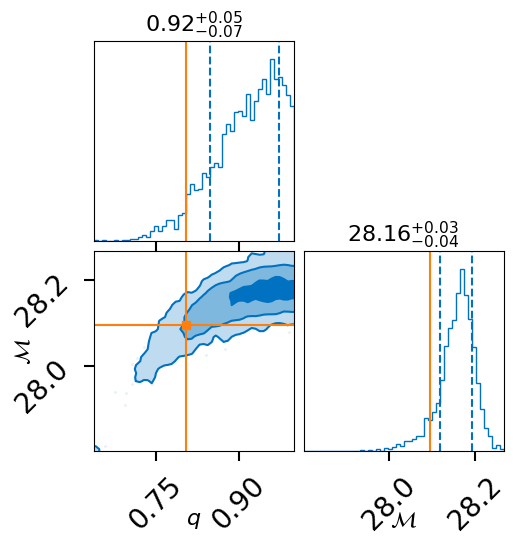

In [6]:
fig = result.plot_corner()
post = result.posterior[['mass_ratio', 'chirp_mass', 'log_prior', 'log_likelihood']]
lnz = result.log_evidence
lnz_err = result.log_evidence_err
fig

In [7]:
print(f"lnZ = {lnz:.2f} +/- {lnz_err:.2f}")
print(f"lnBF = {result.log_bayes_factor:.2f}")

lnZ = -1984.29 +/- 0.10
lnBF = 70.70


NOTE: the LVK stores the log-likelihood - noise log-likelihood in the column labeled 'log-likelihood'.
So, this time instead of computing the FI LnZ, we will compute the FI LnBF.

### Compute FI evidence

In [14]:
lnz_file = f"{OUTDIR}/lnz.npz"
lnzs, r_vals, _ = get_fi_lnz_list(post, r_vals=np.geomspace(1e1, 2e5, 1000), num_ref_params=100, cache_fn=lnz_file)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (2653, 2) 


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

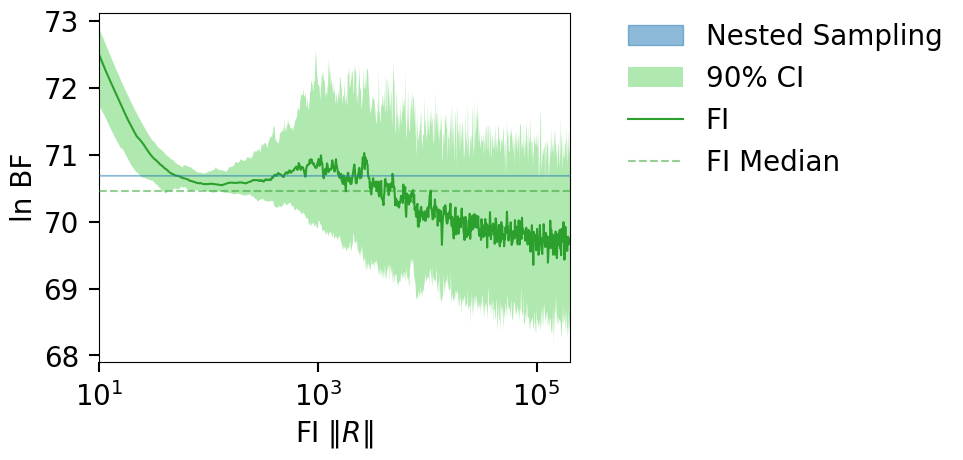

In [15]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[result.log_bayes_factor])
fig = plot_fi_evidence_results(**plt_kwgs)
fig.tight_layout()
fig.gca().set_ylabel(r"ln BF");

(69.5, 73.0)

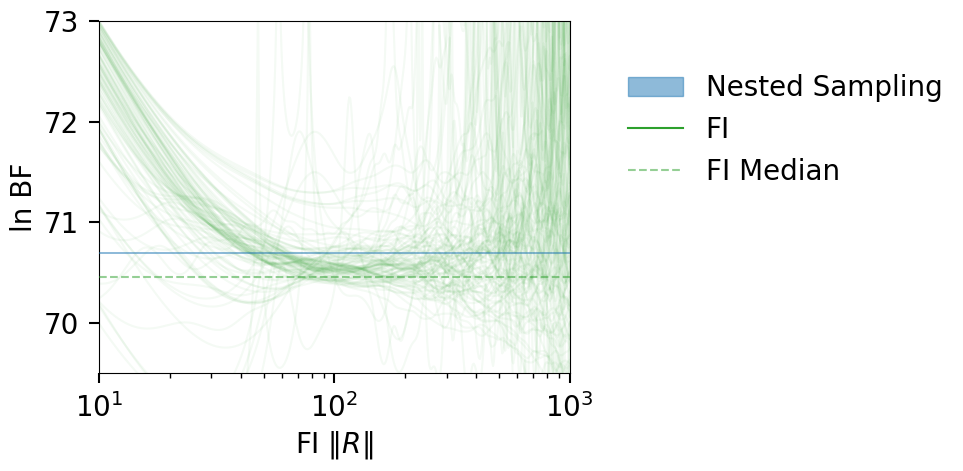

In [21]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plot_ci=False)
fig.tight_layout()
ax = fig.gca()
ax.set_ylabel(r"ln BF");
ax.set_xlim(1e1, 1e3);
ax.set_ylim(69.5, 73)

## 15-D parameter inference

We download a pre-run LVK injection and run the FI LnZ computation on it.
Link to result: [https://zenodo.org/record/7884973](https://zenodo.org/record/7884973)


In [22]:
import bilby

# load the LVK posterior
FPATH = '128_cpus_v1_0_result.hdf5'

LVK_data = namedtuple("LVK_data", "posterior, lnz, lnz_err, lnBF")


def load_lvk_data(fpath):
    r = bilby.gw.result.CBCResult.from_hdf5(fpath)
    post = r.posterior
    sampling_params = r.search_parameter_keys + ['log_likelihood', 'log_prior', 'luminosity_distance']
    lnz, lnz_err = r.log_evidence, r.log_evidence_err
    lnBF = r.log_bayes_factor
    post = post[sampling_params]
    post = post.loc[:, post.nunique() > 1]
    return LVK_data(post, lnz, lnz_err, lnBF)


CBC_data = load_lvk_data(FPATH)

In [23]:
print(f"Posterior shape: {CBC_data.posterior.shape}")
print(f"LnZ: {CBC_data.lnz:.2f} +/- {CBC_data.lnz_err:.2f}")
print(f"LnBF: {CBC_data.lnBF}")
CBC_data.posterior.head().T

Posterior shape: (15196, 17)
LnZ: -16332.68 +/- 0.11
LnBF: 56.96249503300896


,0,1,2,3,4
chirp_mass,17.303518,17.137896,17.406246,17.221114,17.224999
mass_ratio,0.640732,0.363822,0.475442,0.716670,0.535031
a_1,0.122786,0.126647,0.208230,0.124358,0.064088
a_2,0.294212,0.671431,0.858286,0.436716,0.239654
tilt_1,2.671935,1.089454,0.899129,2.487101,1.332991
tilt_2,0.617993,1.095211,1.673787,1.440678,1.530625
phi_12,5.277061,5.083531,0.924704,4.632946,5.622373
phi_jl,5.421349,0.331844,3.584094,4.388201,4.657011
cos_theta_jn,0.649265,-0.750138,-0.906039,-0.887552,-0.956641
psi,3.033949,1.530611,2.617934,1.037721,3.061500


NOTE: the `log-likelihood` column is actually the `lnl-noise Lnl` (the `log-likelihood-ratio`).

### Compute FI LnZ

In [39]:
def run_fi_computer(CBC_data, frac_samp=0.1, n_ref_points=1000, outdir='out_inj_downsampled', clean=False):
    if os.path.exists(outdir) and clean:
        shutil.rmtree(outdir)
    os.makedirs(outdir, exist_ok=True)

    # USING DOWNSAMPLED POSTERIOR SAMPLES
    n_total = len(CBC_data.posterior)
    n_samp = int(n_total * frac_samp)

    post = CBC_data.posterior.sample(
        n_samp,
        weights=np.exp(CBC_data.posterior.log_likelihood)
    )
    print(f"Using {100 * frac_samp:.2f}% of posterior, and {n_ref_points} reference points.")
    lnzs, r_vals, _ = get_fi_lnz_list(
        post,
        num_ref_params=n_ref_points,
        r_vals=np.geomspace(10, 1e9, 100),
        cache_fn=f'{outdir}/lnzs.npz',
        weight_samples_by_lnl=True,
    )
    return lnzs, r_vals

#### Using a downsampled posterior

In [47]:
OUTDIR = 'out_inj_downsampled'
CLEAN = False
lnzs, r_vals = run_fi_computer(CBC_data, frac_samp=0.1, n_ref_points=1000, outdir=OUTDIR, clean=CLEAN)

Using 10.00% of posterior, and 1000 reference points.


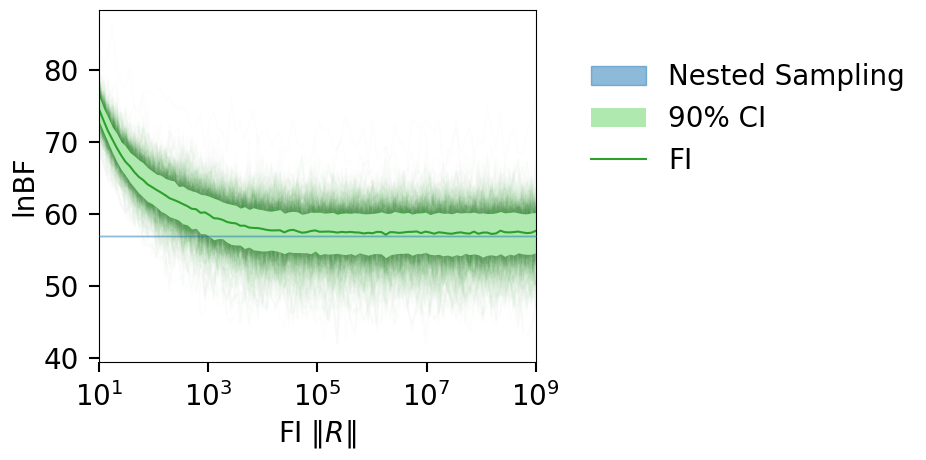

In [58]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[CBC_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=0.01))
fig.gca().set_ylabel("lnBF");

%samples above 10000000.0: 26.00


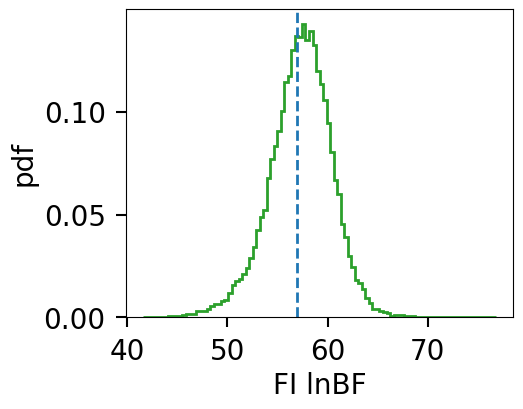

In [70]:
def histogram_fi_lnzs(lnzs, rvals, rval_threshold, true=None):
    idx = np.argmin(np.abs(rvals - rval_threshold))
    lnz = lnzs[:, idx:].ravel()
    print(f"%samples above {rval_threshold}: {len(lnz)/len(lnzs.ravel()) * 100:.2f}")
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.hist(lnz, bins=100, density=True, histtype='step', lw=2, color='tab:green')
    if true is not None:
        ax.axvline(true, ls='--', color='tab:blue', lw=2)
    ax.set_xlabel(r"FI lnBF")
    ax.set_ylabel("pdf")
    return fig

fig = histogram_fi_lnzs(lnzs, r_vals, rval_threshold=1e7, true=CBC_data.lnBF)

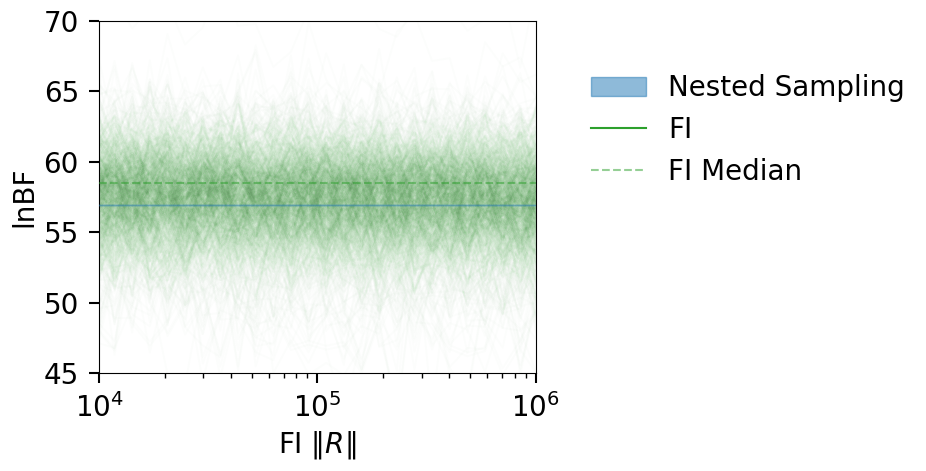

In [56]:
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plot_ci=False, plt_kwgs=dict(alpha=0.01))
ax = fig.gca()
ax.set_ylabel("lnBF");
ax.set_xlim(1e4, 1e6);
ax.set_ylim(45, 70);

#### Using full posterior sample (fewer reference points)

In [45]:
OUTDIR = 'out_inj2'
CLEAN = False
lnzs, r_vals = run_fi_computer(CBC_data, frac_samp=1, n_ref_points=100, outdir=OUTDIR, clean=CLEAN)

|funnel|INFO| Calculating FI LnZ with 100 reference points and a posterior of size: (15196, 15) 


Using 100.00% of posterior, and 1000 reference points.


FI LnZ:   0%|          | 0/100 [00:00<?, ?it/s, FI LnZ: 0]

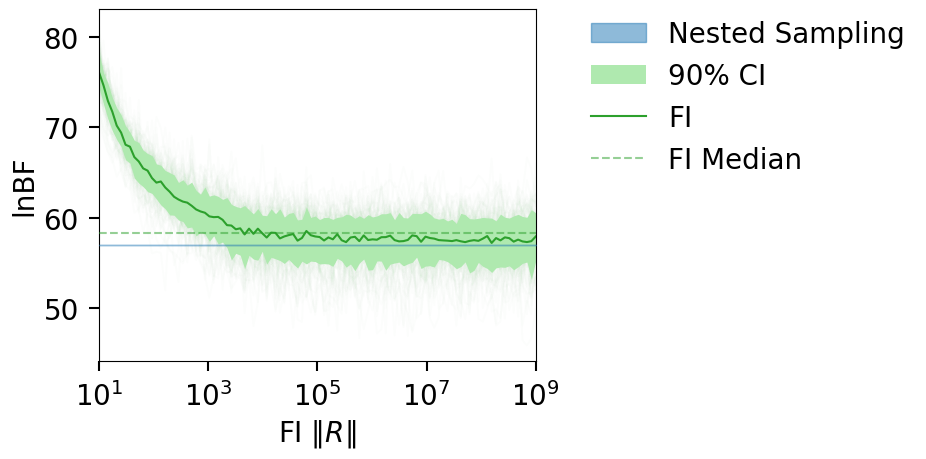

In [46]:
plt_kwgs = dict(lnzs=lnzs, r_vals=r_vals, sampling_lnz=[CBC_data.lnBF])
fig = plot_fi_evidence_results(**plt_kwgs, plot_all_lnzs=True, plt_kwgs=dict(alpha=0.01))
fig.gca().set_ylabel("lnBF");